In [1]:
# the cnn/dailymail dataset

from datasets import load_dataset 
dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"features: {dataset['train'].column_names}")

Found cached dataset cnn_dailymail (/home/jim/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

features: ['article', 'highlights', 'id']


In [2]:
example_id = 40767

sample = dataset["train"][example_id]
print(f"""
      Article (excerpt of 500 characters, total length: {len(sample["article"])}):
      """)
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])



      Article (excerpt of 500 characters, total length: 3192):
      
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n

Summary (length: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


In [3]:
# text summarization pipelines
sample_text = dataset["train"][example_id]["article"][:2000]
# we'll collect the generated summaries of each model in a dictionary
summaries={}


In [4]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to /home/jim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

In [5]:
# summarization baseline
def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])

In [6]:
summaries["baseline"] = three_sentence_summary(sample_text)

In [7]:
# gpt
from transformers import pipeline, set_seed

set_seed(42)

pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query):]))

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [8]:
# t5
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [9]:
# bart
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [10]:
# pegasus
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")


In [11]:

pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [12]:
# comparing different summaries
print("GROUND TRUTH")
print(dataset["train"][example_id]["highlights"])
print("")

for model_name in summaries:
  print(model_name.upper())
  print(summaries[model_name])
  print("")
  

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.

GPT2
- Usain Bolt wins his third gold of the 2014 world championships
- Usain Bolt joins Carl Lewis, Michael Johnson and Allyson Felix on eight Olympic gold medals at the Games

T5
usain bolt wins his third gold medal of the world championships in the men's 4x100m relay .
the 26-year-old anchored Jamaica to victory in t

In [13]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")


/tmp/ipykernel_73790/3652189877.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [14]:
import pandas as pd
import numpy as np

bleu_metric.add(prediction="the the the the the the", 
                reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])


,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [15]:
bleu_metric.add(prediction="the cat is on mat", 
                reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


In [16]:
#ROUGE

rouge_metric = load_metric("rouge")
reference = dataset["train"][example_id]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
  rouge_metric.add(prediction=summaries[model_name], 
                   reference=reference)
  score = rouge_metric.compute()
  rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
  records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.413793,0.178571,0.344828,0.379310
t5,0.486486,0.222222,0.378378,0.486486
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


In [17]:
#evaluating t5-small on the cnn/dailymail dataset
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article", 
                                column_summary="highlights"):
  summaries = [three_sentence_summary(text) for text in dataset[column_text]]
  metric.add_batch(predictions=summaries, 
                   references=dataset[column_summary])
  score = metric.compute()
  return score
  

In [18]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(100))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.386229,0.16465,0.245916,0.352733


In [4]:
from tqdm import tqdm 
import torch 

device = "cuda" if torch.cuda.is_available() else "cpu" 

def chunks(list_of_elements, batch_size):
  for i in range(0, len(list_of_elements), batch_size):
    yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
  article_batches = list(chunks(dataset[column_text], batch_size))
  target_batches = list(chunks(dataset[column_summary], batch_size))

  for article_batch, target_batch in tqdm(zip(article_batches, target_batches), 
                                          total=len(article_batches)):
    inputs = tokenizer(article_batch, max_length=1024, truncation=True, 
                       padding="max_length", return_tensors="pt")
    summaries = model.generate(
        input_ids=inputs["input_ids"].to(device), 
        attention_mask=inputs["attention_mask"].to(device), 
        length_penalty=0.8, num_beams=8, max_length=128)
    decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                          clean_up_tokenization_spaces=True) 
                         for s in summaries]
    decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
    metric.add_batch(predictions=decoded_summaries, references=target_batch)
  
  score = metric.compute()
  return score


In [20]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, 
                                   model, tokenizer, batch_size=1) # changed batch_size from 8 to 1 to fit into my GPU
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])



100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.425433,0.201681,0.300942,0.362527


**Training a Summarization Model**

In [3]:
from datasets import load_dataset

dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])



Found cached dataset samsum (/home/jim/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [24]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))


Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [25]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, 
                                   model, tokenizer, column_text="dialogue", 
                                   column_summary="summary", batch_size=1)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])


100%|██████████| 819/819 [29:13<00:00,  2.14s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296038,0.087469,0.229174,0.229574


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


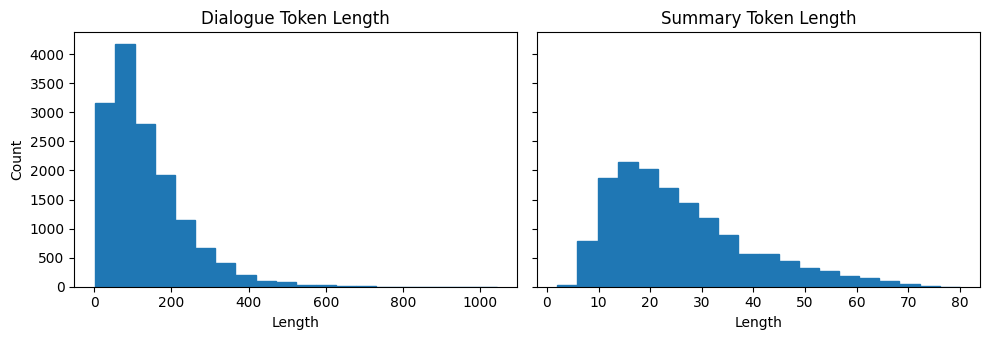

In [26]:
import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2,  figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")

plt.tight_layout()
plt.show()



In [27]:
def convert_examples_to_features(example_batch):
  input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, 
                              truncation=True)
  with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(example_batch["summary"], max_length=128, 
                                 truncation=True)
  return {"input_ids": input_encodings["input_ids"], 
          "attention_mask": input_encodings["attention_mask"], 
          "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)


Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [29]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collector = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer 

training_args = TrainingArguments(
    output_dir='pegasusm-samsum', num_train_epochs=1, warmup_steps=500, 
    per_device_train_batch_size=1, per_device_eval_batch_size=1, 
    weight_decay=0.01, logging_steps=10, push_to_hub=False, 
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6, 
    gradient_accumulation_steps=16)

trainer = Trainer(model=model, args=training_args, 
                  tokenizer=tokenizer, data_collator=seq2seq_data_collector, 
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

trainer.train()



In [6]:
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer

model_ckpt = "transformersbook/pegasus-samsum"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)



In [ ]:
from datasets import load_metric 

model.to(device)
rouge_metric = load_metric("rouge")
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, model, tokenizer, 
    batch_size=1, column_text="dialogue", column_summary="summary")


In [12]:
import pandas as pd
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.440495,0.211686,0.349627,0.349962


In [15]:
from transformers import pipeline

gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]

pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])



Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.


In [16]:
custom_dialogue = """\
 Thom: Hi guys, have you heard of transformers?
 Lewis: Yes, I used them recently!
 Leandro: Indeed, there is a great library by Hugging Face.
 Thom: I know, I helped build it ;)
 Lewis: Cool, maybe we should write a book about it. What do you think?
 Leandro: Great idea, how hard can it be?!
 Thom: I am in!
 Lewis: Awesome, let's do it together!
 """

print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Thom, Lewis and Leandro are going to write a book about transformers. Thom helped build a library by Hugging Face. They are going to do it together.
